In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import interactive 
%matplotlib inline
# %matplotlib qt
interactive(True)

hd_print = lambda msg: print('\n' + msg, '\n' + '-' * len(msg.expandtabs()))


"""
Load data
"""
import sys

ROOT_DIR = '..'
sys.path.append(ROOT_DIR)

import global_settings as gs
from Config import Config
from Dataset import Dataset
from utils import plot_utils
import global_settings as gs

conf_params = {
    'data_path' : '../data/08-11-19_data.pickle',
    'test_split': 0.3,
    'val_split' : 0.3,
    #'input_shape':
    'shuffle_specimens': [0, 2, 1]
}
conf = Config(filename=None, params=conf_params)

d = Dataset(conf)
print('Shape info')
d.shape_info()

Shape info
X_train:   (367002, 21)
Y_train:   (367002,)
X_val:     (157286, 21)
Y_val:     (157286,)
X_test:    (262144, 21)
Y_test:    (262144,)


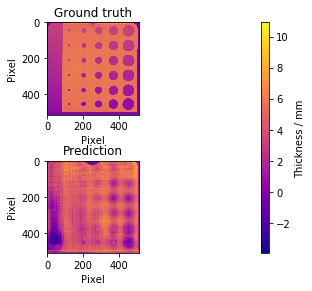

In [75]:
def plot_ground_truth_vs_prediction(y, y_pred, gs, cmap='plasma', output_dir=None, suffix=''):
    """
    Plots the ground truth and the prediction
    :param np.ndarray y: ground truth with shape (H, W)
    :param np.ndarray y_pred: prediction with shape (H, W)
    :param gs: global settings
    :param str cmap:
    :param str|None output_dir:
    :param str|int suffix:
    :return:
    """

    vmin = min(y.min(), y_pred.min())
    vmax = max(y.max(), y_pred.max())
    y      = y.reshape(gs.H, gs.W)
    y_pred = y_pred.reshape(gs.H, gs.W)
    plt.subplot(211)
    plt.imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title('Ground truth')
    plt.xlabel('pixel')
    plt.ylabel('pixel')
    plt.subplot(212)
    plt.title('Prediction')
    plt.xlabel('pixel')
    plt.ylabel('pixel')
    plt.tight_layout()
    plt.imshow(y_pred, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5)
    cax = plt.axes([0.85, 0.1, 0.02, 0.8])
    cb = plt.colorbar(cax=cax)
    cb.set_label('Thickness / mm')
    if output_dir and os.path.isdir(output_dir):
        suffix = str(suffix)
        if suffix != '':
            suffix = '_%s' % suffix.zfill(3)
            plt.savefig(os.path.join(output_dir, 'ground_truth_vs_prediction%s.png' % suffix))
            plt.close()
    else:
        plt.show()
        
plot_ground_truth_vs_prediction(d.Y_test, y_pred, gs)

In [133]:
def plot_ground_truth_vs_prediction_flattened(y, y_pred, slicing_step=500):
    y            = y.reshape(-1)
    sort_indices = np.argsort(y)
    y            = y[sort_indices]
    y_pred       = y_pred.reshape(-1)
    y_pred       = y_pred[sort_indices]
    
    slicing_step_str = ''
    if slicing_step and slicing_step > 0:
        y      = y[0::slicing_step]
        y_pred = y_pred[0::slicing_step]
        slicing_step_str = ' (every %dth sample)' % slicing_step
    y_ticks = np.arange(int(min(y.min(), y_pred.min())), int(max(y.max(), y_pred.max())), 1)
    
    #%matplotlib qt
    plt.plot(y, 'g-', label='Ground truth')
    plt.plot(y_pred, 'r.', label='Prediction')
    plt.xlabel('pixel')
    plt.ylabel('Thickness / mm')
    plt.yticks(y_ticks)
    plt.title('Ground truth versus prediction%s' % slicing_step_str)
    plt.legend()
    plt.show()

plot_ground_truth_vs_prediction_flattened(d.Y_test, y_pred)

In [134]:
def plot_ground_truth_and_prediction_histograms(y, y_pred, num_bins=10):
    %matplotlib qt
    y      = y.reshape(-1)
    y_pred = y_pred.reshape(-1)
    bins   = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), num_bins)
    plt.xticks(bins)
    
    hist_y      = plt.hist(y,      bins, fc=(0, 1, 0, 1),   ls='dashed', align='mid', label='Ground truth')
    hist_y_pred = plt.hist(y_pred, bins, fc=(1, 0, 0, 0.5), ls='dotted', align='mid', label='Prediction')
    plt.xlabel('Thickness / mm')
    plt.ylabel('Count')
    plt.title('Histograms of ground truth and prediction')
    plt.legend()
    
    # print('Bin\tCounts y\tCounts y_pred')
    header = 'Bin\tCounts y\tCounts y_pred'
    hd_print(header)
    for b_idx, b in enumerate(bins[:-1]):
        print('%.2f\t%d\t\t%d' % (b, hist_y[0][b_idx], hist_y_pred[0][b_idx]))
    plt.show()

plot_ground_truth_and_prediction_histograms(d.Y_test, y_pred)


Bin	Counts y	Counts y_pred 
-------------------------------------
-3.94	0		1325
-2.28	0		4450
-0.63	33562		11669
1.02	44986		32679
2.67	25386		88980
4.32	151843		108398
5.97	6367		14145
7.62	0		450
9.27	0		48


In [116]:
def plot_ground_truth_and_prediction_difference_histogram(y, y_pred, num_bins=10):
    diff      = abs(y - y_pred)
    bins      = np.linspace(diff.min(), diff.max(), num_bins)
    print(bins)
    hist_diff = plt.hist(diff, bins, fc=(0, 1, 0, 1), ls='dashed', align='mid')
    plt.xticks(bins)
    plt.xlabel('Absolute difference / mm')
    plt.ylabel('Count')
    plt.title('Histograms of absolute difference between ground truth and prediction')
    plt.show()

plot_ground_truth_and_prediction_difference_histogram(d.Y_test, y_pred)

[2.03091147e-05 1.05298224e+00 2.10594417e+00 3.15890610e+00
 4.21186803e+00 5.26482996e+00 6.31779189e+00 7.37075382e+00
 8.42371575e+00 9.47667768e+00]


In [117]:
def plot_errors_per_bin(y, y_pred, use_min_dist_to_bin=True, output_dir=None, suffix='',
                        metrics=('mae', 'mse', 'rmse', 'r2'),
                        bins=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0)):
    """
    :param y:
    :param y_pred:
    :param output_dir:
    :param use_min_dist_to_bin:
    :param suffix:
    :param metrics:
    :param bins:
    :return:
    """

    # reshape and sort both arrays
    y      = y.reshape(-1)
    y_pred = y_pred.reshape(-1)
    sort_indices = np.argsort(y)
    y      = y[sort_indices]
    y_pred = y_pred[sort_indices]

    # compute differences between prediction and ground truth for each bin
    num_bins = len(bins)
    bin_diffs = [[] for i in range(num_bins)]
    if use_min_dist_to_bin:
        for i, y in enumerate(y):
            bin_idx = np.argmin(np.abs(bins - y))
            diff = (y - y_pred[i])
            bin_diffs[bin_idx].append(diff)
    else:
        for i, thresh in enumerate(bins):
            bin_indices = np.argwhere(y <= thresh)
            bin_diffs[i] = y[bin_indices] - y_pred[bin_indices]
            y_true = np.delete(y, bin_indices)
            y_pred = np.delete(y_pred, bin_indices)
    
        remaining_diff = (y - y_pred).reshape(-1, 1)
        bin_diffs[i] = np.concatenate((bin_diffs[i], remaining_diff), axis=0)
    
    # create plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    all_diffs = np.asarray([x for sublist in bin_diffs for x in sublist])
    global_error = -1
    for i, m in enumerate(metrics):
        if m == 'mae':
            bin_errors = [np.mean(np.abs(diff)) for diff in bin_diffs]
            global_error = np.mean(np.abs(all_diffs))
        elif m == 'mse':
            bin_errors = [np.mean(np.square(diff)) for diff in bin_diffs]
            global_error = np.mean(np.square(all_diffs))
        elif m == 'rmse':
            bin_errors = [np.sqrt(np.mean(np.abs(diff))) for diff in bin_diffs]
            global_error = np.sqrt(np.mean(np.abs(all_diffs)))
        elif m == 'r2':
            # bin errors not correct here
            bin_errors = [1 - ((np.square(diff)).sum() / (np.square(diff - np.mean(diff))).sum()) for diff in bin_diffs]
            global_error = 1 - ((np.square(all_diffs)).sum() / (np.square(y - np.mean(y))).sum())
        else:
            continue

        # TODO: write them to file?
        print('Total error %4s: %f' % (m, global_error))

        plt.plot(bins, bin_errors, '-x', label='%s [%.3f]' % (m, global_error))
        for k, l in zip(bins, bin_errors):
            l = round(l, 3)
            ax.annotate(str(l), xy=(k, l))
        plt.title('Errors for each bin')
        plt.xticks(bins)
        plt.legend()
    
    if output_dir and os.path.isdir(output_dir):
        suffix = str(suffix)
        if suffix != '':
            suffix = '_%s' % suffix.zfill(3)
        plt.savefig(os.path.join(output_dir, 'errors_per_bin%s.png' % suffix))
        plt.close()
    else:
        plt.show()
            
plot_errors_per_bin(d.Y_test, y_pred, metrics=['mae'])

Total error  mae: 1.361894



Running linear regression 
-------------------------
Regression R^2 score for train: 0.5079955067057425
Regression R^2 score for test: 0.3459463192368871
Regression coefficients
 [-4.63371364e+00 -3.22017144e-02 -2.75445456e+00 -1.20046832e+01
 -2.82276021e+00  2.73563667e+01  2.00946811e+01 -2.04970379e+01
 -7.43544217e+00  1.72158849e+01  3.62511538e+00 -6.71035980e+00
 -7.73360903e+00 -4.27842910e+01  2.74162006e+01  9.54373850e+00
 -2.80886719e+01 -2.27719321e+01  4.24817790e+01  2.02926154e+01
 -8.47204437e+00]


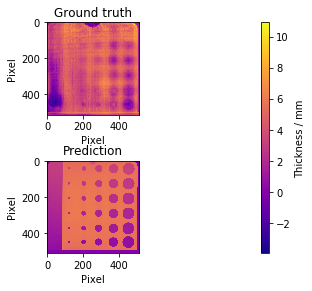

Total error  mae: 1.361894
Total error  mse: 2.971447
Total error   r2: 0.345946


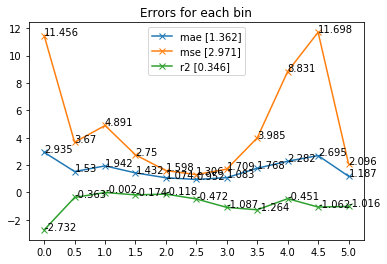

In [2]:
"""
Linear regression
"""
from sklearn.linear_model import LinearRegression

hd_print('Running linear regression')
reg = LinearRegression(fit_intercept=False).fit(d.X_train, d.Y_train)
r2 = reg.score(d.X_train, d.Y_train)
print('Regression R^2 score for train:', r2)
r2 = reg.score(d.X_test, d.Y_test)
print('Regression R^2 score for test:', r2)
print('Regression coefficients\n', reg.coef_)
y_pred = reg.predict(d.X_test)
plot_utils.plot_ground_truth_vs_prediction(y_pred, d.Y_test, gs)
plot_utils.plot_errors_per_bin(d.Y_test, y_pred, metrics=['mae', 'mse', 'r2'])


Running BayesianRidge regression 
--------------------------------
Regression R^2 score for train: 0.5220482306340839
Regression R^2 score for test: 0.35853968963603766
Regression coefficients
 [ -4.46933515  -2.27337156  -1.23128414  -8.61961737   1.45076364
  24.52509197  19.15288003 -12.83880906 -10.86304093   1.73283586
  -2.52443654   9.53266298 -11.26453628 -47.34665537  24.23917239
  21.90280381 -23.85994254 -21.60017096  35.22969189  17.39013532
  -9.32011597]


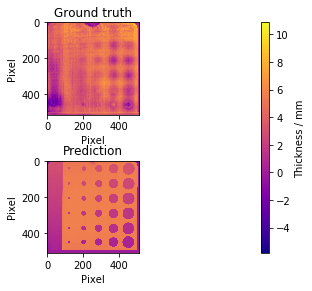

Total error  mae: 1.341550
Total error  mse: 2.805493
Total error   r2: 0.358540


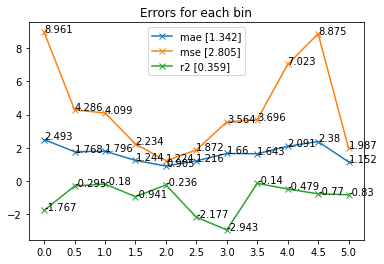

In [13]:
"""
BayesianRidge Regression
"""
from sklearn.linear_model import BayesianRidge

hd_print('Running BayesianRidge regression')
reg = BayesianRidge().fit(d.X_train, d.Y_train)
r2 = reg.score(d.X_train, d.Y_train)
print('Regression R^2 score for train:', r2)
r2 = reg.score(d.X_test, d.Y_test)
print('Regression R^2 score for test:', r2)
print('Regression coefficients\n', reg.coef_)
y_pred = reg.predict(d.X_test)

plot_utils.plot_ground_truth_vs_prediction(y_pred, d.Y_test, gs)
plot_utils.plot_errors_per_bin(y_pred, d.Y_test, metrics=['mae', 'mse', 'r2'])


Running MLP regression 
----------------------
Regression R^2 score for train: 0.8668035164988145
Regression R^2 score for test: 0.694224910754484
Regression coefficients
 [ -4.46933515  -2.27337156  -1.23128414  -8.61961737   1.45076364
  24.52509197  19.15288003 -12.83880906 -10.86304093   1.73283586
  -2.52443654   9.53266298 -11.26453628 -47.34665537  24.23917239
  21.90280381 -23.85994254 -21.60017096  35.22969189  17.39013532
  -9.32011597]


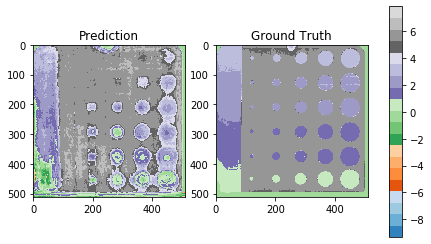

Total error  mae: 0.755581
Total error  mse: 1.337339
Total error rmse: 0.869242
Total error   r2: 0.694225


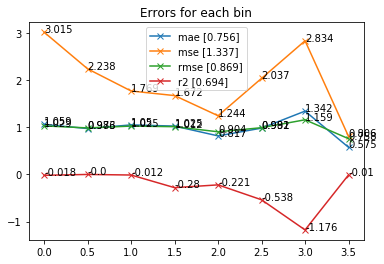

In [9]:
"""
MLP regression
"""
from sklearn.neural_network import MLPRegressor

hd_print('Running MLP regression')
mlp = MLPRegressor(activation='relu', learning_rate='adaptive', early_stopping=True).fit(d.X_train, d.Y_train)
r2 = mlp.score(d.X_train, d.Y_train)
print('Regression R^2 score for train:', r2)
r2 = mlp.score(d.X_test, d.Y_test)
print('Regression R^2 score for test:', r2)
print('Regression coefficients\n', reg.coef_)
y_pred = mlp.predict(d.X_test)
plot_prediction_vs_ground_truth(y_pred, d.Y_test)
plot_error_per_bin(y_pred, d.Y_test, metrics=['mae', 'mse', 'rmse', 'r2'])

In [ ]:
"""
SVM regression
"""
from sklearn.svm import SVR

hd_print('Running SVM regression')
reg = SVR(gamma='auto', epsilon=0.2, verbose=True).fit(d.X_train, d.Y_train)
r2 = reg.score(d.X_train, d.Y_train)
print('Regression R^2 score for train:', r2)
r2 = reg.score(d.X_test, d.Y_test)
print('Regression R^2 score for test:', r2)
print('Regression coefficients\n', reg.coef_)
y_pred = reg.predict(d.X_test)
plot_prediction_vs_ground_truth(y_pred, d.Y_test)
plot_error_per_bin(y_pred, d.Y_test, metrics=['mae', 'mse', 'rmse', 'r2'])


Running SVM regression 
----------------------
[LibSVM]